In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import spaces

import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


In [5]:
class GridWorld(gym.Env):
    def __init__(self, grid_size=10):
        super(GridWorld, self).__init__()
        self.grid_size = grid_size
        self.num_tiles = self.grid_size * self.grid_size

        self.grid_agent = np.zeros((self.grid_size, self.grid_size), dtype=np.float32)
        self.grid_food = np.zeros((self.grid_size, self.grid_size), dtype=np.float32)
        self.opponents = np.zeros((self.grid_size, self.grid_size), dtype=np.float32)

        self.agent_position = np.random.randint(0, grid_size+1, 2)

        # Define action space and observation space
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.grid_size, self.grid_size, 3), dtype=np.float32)

    def reset(self):
        # Reset the environment to the initial state
        self.grid_agent = np.zeros((self.grid_size, self.grid_size), dtype=np.float32)
        self.grid_food = np.zeros((self.grid_size, self.grid_size), dtype=np.float32)
        self.opponents = np.zeros((self.grid_size, self.grid_size), dtype=np.float32)
        self.agent_position = np.random.randint(0, grid_size+1, 2)

        return self._get_observation()

    def step(self, action):
        # Take an action in the environment
        self._move_agent(action)

        # Calculate the reward
        reward = self._calculate_reward()

        # Check if episode is done (e.g., agent reaches goal, runs out of oxygen, etc.)
        done = self._is_episode_done()

        return self._get_observation(), reward, done, {}

    def render(self, mode='human'):
        # Visualize the environment state (optional)
        # Here, we print the grid with agent's position, food, and other agent
        print(f"Agent Position:\n{self.grid_agent}\n")
        print(f"Food:\n{self.grid_food}\n")
        print(f"opponents:\n{self.opponents}\n")

    def close(self):
        # Perform any necessary cleanup or finalization steps (optional)
        pass

    def _move_agent(self, action):
        # Move the agent based on the selected action
        x, y = self.agent_position

        if action == 0:  # Up
            x -= 1
        elif action == 1:  # Down
            x += 1
        elif action == 2:  # Left
            y -= 1
        elif action == 3:  # Right
            y += 1

        # Check if the new position is within grid boundaries
        if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
            self.agent_position = (x, y)

    def _calculate_reward(self):
        # Calculate the reward based on the state of the environment
        return 0  # Update with your reward calculation logic

    def _is_episode_done(self):
        # Check if the episode is done based on some termination conditions
        return False  # Update with your termination condition logic

    def _get_observation(self):
        # Get the current observation and stack the arrays together
        observation = np.stack((self.grid_agent, self.grid_food, self.opponents), axis=2)
        return observation


gym.register(
    id='GridWorld',
    entry_point=GridWorld
)

In [2]:
class DQNAgent:
    def __init__(self, state_shape, action_size):
        def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

        self.food = 50

    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=self.state_shape))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [21]:
env = gym.make('GridWorld')

n_actions = env.action_space.n
state_shape = (10, 10, 3)

dqn = DQNAgent(n_actions, n_states)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 10)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/keras

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100

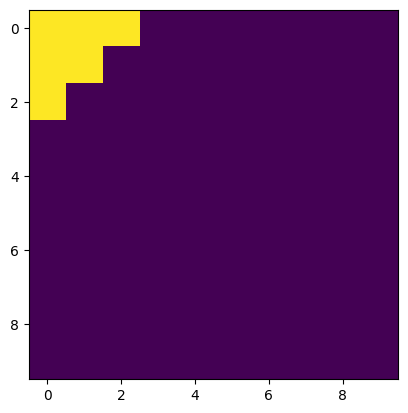

In [19]:
grid = np.zeros((10,10))
grid[(0,1,0,1,2,0), (0,0,1,1,0,2)] = 1

plt.imshow(grid)